# 一、常见的RSA攻击
介绍一下RSA加密  
选取一个两个素数$p$，$q$，$n=p*q$  
$$\phi(n) = (p-1)*(q-1)$$
选取一个公私钥对$e$，$d$，使得$e*d\equiv 1\;(\%\;phi(n))$  
加密:
$$c = m^e\;(\%\;n)$$
解密：
$$m = c^d\;(\%\;n)$$  
RSA破解难度就在于大整数的质因数分解特别困难

### 1、 已知p, q, e, 求d
>e = 65537  
>p = 273821108020968288372911424519201044333  
>q = 280385007186315115828483000867559983517  

>### 扩展欧几里得求逆元
>我们已经知道扩展欧几里得算法是用来求解下面这样的一个式子的
>$$ax+by = c$$
>那么我们假设exgcd(a, b, x, y)为下面这样一个式子的解
>$$ax+by = gcd(a, b)$$
>- 考虑边界情况，当b = 0时，可以得到如下解 $ax=gcd(a,0)$ 
>$$\left\{\begin{aligned}x&=1\\y&=0\end{aligned}\right.$$
>- 对于一般情况，考虑迭代，设$a^{'} = b,\; b^{'} = a \% b$，有  
  
>$$a^{'}x^{'}+b^{'}y^{'}=gcd(a^{'}, b^{'})=gcd(b, a\%b)=gcd(a, b)$$
>>$gcd(a, b) = gcd(b, a\%b)$恒成立  

>所以有$$a^{'}x^{'}+b^{'}y^{'}=ax+by$$
替换掉$a^{'}$和$b^{'}$后：
$$bx^{'} + (a\%b)y^{'}=ax+by$$
>又因为$a\%b=a-\llcorner\frac{a}{b}\lrcorner b$，
>所以有
$$bx^{'}+(a-\llcorner\frac{a}{b}\lrcorner) b)y^{'}=ax+by$$
整理一下上式可以得到
$$ay^{'} + b(x^{'}-\llcorner\frac{a}{b}\lrcorner y^{'})=ax+by$$
可以得到：
$$\left\{\begin{aligned}x&=y^{'}\\y&=x^{'}-\llcorner\frac{a}{b}\lrcorner y^{'}\end{aligned}\right.$$

>**那么如何使用扩展欧几里得求逆元呢？**  
>  
>已知e在模n下的逆元定义式如下：
$$e*d \equiv 1 \;(\%\;n)$$
那么一定存在k，使得下式成立：
$$e*d = k*n + 1$$
转化一下得到：
$$e*d-k*n=1$$
用 $t$ 代替 $-k$ 得到：
$$e*d+t*n=1$$
所以可以用`exgcd(e, n)`来求出`d`


In [13]:
e = 65537
p = 273821108020968288372911424519201044333
q = 280385007186315115828483000867559983517

def exgcd(a, b):
    if b == 0:
        return 1, 0, a
    x, y, gcd = exgcd(b, a % b)
    return y, x - a // b * y, gcd

def get_inv(a, b):
    x, y, gcd = exgcd(a, b)
    if gcd != 1:
        return -1
    else:
        return x, y, gcd
    
d = get_inv(e, (p-1)*(q-1))[0] % ((p-1) * (q-1))

print(hex(d))

0x6e1e3e007175af5e532b14628edda62d1d0f7561a926a10f29853bde0a5ed611


上面是手动实现求逆元的代码，当然在模n为素数的时候，还可以使用费马小定理来求$d = e^{n-2}\%n$

我们这里还可以使用gmpy2库求逆元  

>gmpy2库是一个大整数库，该库含有对大整数的一系列运算，包括加减乘除、求逆元、快速幂、开方等

In [15]:
import gmpy2

e = 65537
p = 273821108020968288372911424519201044333
q = 280385007186315115828483000867559983517
phi_n = (p - 1) * (q - 1)
print(hex(gmpy2.invert(e, phi_n)))

0x6e1e3e007175af5e532b14628edda62d1d0f7561a926a10f29853bde0a5ed611


### 2、给定p, q, e，以及密文c，求明文m
>e = 65537  
p = 273821108020968288372911424519201044333  
q = 280385007186315115828483000867559983517  
c = 0xa6e8ccbd0756d0c7e250281f079984f89dcf17a90e5b333e26322cc8de5ed12e

>RSA加密过程
$$c = m^{e} \% n$$
>RSA解密过程
$$m = c^{d} \% n$$

In [19]:
import gmpy2

e = 65537
p = 273821108020968288372911424519201044333
q = 280385007186315115828483000867559983517
c = 0xa6e8ccbd0756d0c7e250281f079984f89dcf17a90e5b333e26322cc8de5ed12e
n = p * q
phi_n = (p-1) * (q-1)

def num2str(num):
    s = ''
    while num:
        s += chr(num & 0xff)
        num >>= 8
    return s[::-1]

# 求逆元
d = gmpy2.invert(e, phi_n)
# 快速幂
m = gmpy2.powmod(c, d, n)
print(num2str(m))

flag{this_is_flag}


### 3、给定公钥key.pem，密文cip.bin，求明文
有个东西叫`openssl`，可以用来解析`pem`文件  
还有个别人写好的代码叫RsaCtftool，拉过去解一下就可以，这里就不演示了
>openssl用法:  
>```shell
>$ openssl rsa -pubin -in key.pem -text -modulus
>```

>publickey.pem结构：
>```
>modulus:   n  
>Exponents:  e
>```

>### 对n进行质因数分解  
>- factordb.com
>- yafu分解(在p与q相差很大或很小的时候可以快速求出p,q)
>- 公共质因子求n (题目给定两个n，有公共质因子)，那么可以直接可以得到：p = gcd(n1, n2)

那么知道p, q, e和密文，解密就如上面的步骤一样了

In [1]:
import gmpy2

n1 = 23220619839642624127208804329329079289273497927351564011985292026254914394833691542552890810511751239656361686073628273309390314881604580204429708461587512500636158161303419916259271078173864800267063540526943181173708108324471815782985626723198144643256432774984884880698594364583949485749575467318173034467846143380574145455195152793742611717169602237969286580028662721065495380192815175057945420182742366791661416822623915523868590710387635935179876275147056396018527260488459333051132720558953142984038635223793992651637708150494964785475065404568844039983381403909341302098773533325080910057845573898984314246089
n2 = 22642739016943309717184794898017950186520467348317322177556419830195164079827782890660385734113396507640392461790899249329899658620250506845740531699023854206947331021605746078358967885852989786535093914459120629747240179425838485974008209140597947135295304382318570454491064938082423309363452665886141604328435366646426917928023608108470382196753292656828513681562077468846105122812084765257799070754405638149508107463233633350462138751758913036373169668828888213323429656344812014480962916088695910177763839393954730732312224100718431146133548897031060554005592930347226526561939922660855047026581292571487960929911

p = gmpy2.gcd(n1, n2)
assert gmpy2.is_prime(p)

print('p =', p)

p = 138376604533530412400239558340424700312412702699022481119357799054715877829291635290832719835033140580690053865677079316241919169166375123691917675235979462772103681398725285808551041924624882840901583892858174270714471366531758975241868470938138238307005782651296179579961869801841395682782645916848523771439


### 4、共模攻击
有一种题目，给了你多份文件(n, e, c),其中有两份的n是相同的，且两份公钥都是对相同的明文进行加密，也就是说：
$$c_1 = m^{e_1}\;\%\;n\;\;\;(1)$$
$$c_2 = m^{e_2}\;\%\;n\;\;\;(2)$$
  
根据上式，若$e_1$,$e_2$互质，那么一定存在x, y使得:
$$xe_1+ye_2=gcd(e_1,e_2)$$
那么$(1)^x*(2)^y$可以得到：
$$c_1^x*c_2^y=m^{xe_1+ye_2}\;(\%\;n)=m\;(\%\;n)$$
例如:
>n=21660190931013270559487983141966347279666044468572000325628282578595119101840917794617733535995976710097702806131277006786522442555607842485975616689297559583352413160087163656851019769465637856967511819803473940154712516380580146620018921406354668604523723340895843009899397618067679200188650754096242296166060735958270930743173912010852467114047301529983496669250671342730804149428700280401481421735184899965468191802844285699985370238528163505674350380528600143880619512293622576854525700785474101747293316814980311297382429844950643977825771268757304088259531258222093667847468898823367251824316888563269155865061
>    
>c1=11623242520063564721509699039034210329314238234068836130756457335142671659158578379060500554276831657322012285562047706736377103534543565179660863796496071187533860896148153856845638989384429658963134915230898572173720454271369543435708994457280819363318783413033774014447450648051500214508699056865320506104733203716242071136228269326451412159760818676814129428252523248822316633339393821052614033884661649376604245744651142959498917235138077366818109892738298251161767344501687113868331134288984466294415889635863660753717476594011236542159800099371872396181448655448842148998667568104710807411358117939831241620315
>  
>c2=8180690717251057689732022736872836938270075717486355807317876695012318283159440935866297644561407238807004565510263413544530421072353735781284166685919420305808123063907272925594909852212249704923889776430284878600408776341129645414000647100303326242514023325498519509077311907161849407990649396330146146728447312754091670139159346316264091798623764434932753276554781692238428057951593104821823029665203821775755835076337570281155689527215367647821372680421305939449511621244288104229290161484649056505784641486376741409443450331991557221540050574024894427139331416236263783977068315294198184169154352536388685040531  
>  
>e1=65537  
>  
>e2=70001  

In [6]:
import gmpy2


def num2str(n):
    s = ''
    while n:
        s += chr(n & 0xff)
        n >>= 8
    return s[::-1]

n = 21660190931013270559487983141966347279666044468572000325628282578595119101840917794617733535995976710097702806131277006786522442555607842485975616689297559583352413160087163656851019769465637856967511819803473940154712516380580146620018921406354668604523723340895843009899397618067679200188650754096242296166060735958270930743173912010852467114047301529983496669250671342730804149428700280401481421735184899965468191802844285699985370238528163505674350380528600143880619512293622576854525700785474101747293316814980311297382429844950643977825771268757304088259531258222093667847468898823367251824316888563269155865061
c1 = 11623242520063564721509699039034210329314238234068836130756457335142671659158578379060500554276831657322012285562047706736377103534543565179660863796496071187533860896148153856845638989384429658963134915230898572173720454271369543435708994457280819363318783413033774014447450648051500214508699056865320506104733203716242071136228269326451412159760818676814129428252523248822316633339393821052614033884661649376604245744651142959498917235138077366818109892738298251161767344501687113868331134288984466294415889635863660753717476594011236542159800099371872396181448655448842148998667568104710807411358117939831241620315
c2 = 8180690717251057689732022736872836938270075717486355807317876695012318283159440935866297644561407238807004565510263413544530421072353735781284166685919420305808123063907272925594909852212249704923889776430284878600408776341129645414000647100303326242514023325498519509077311907161849407990649396330146146728447312754091670139159346316264091798623764434932753276554781692238428057951593104821823029665203821775755835076337570281155689527215367647821372680421305939449511621244288104229290161484649056505784641486376741409443450331991557221540050574024894427139331416236263783977068315294198184169154352536388685040531
e1=65537
e2=70001

gcd, x, y = gmpy2.gcdext(e1, e2)
m = gmpy2.powmod(c1, x, n) * gmpy2.powmod(c2, y, n) % n
print(num2str(m))

flag{gongmogongji}


### 5、低加密指数攻击
低加密指数攻击，顾名思义就是给定的e非常小，  
我们知道RSA加密为$$c=m^e\;\%n$$  
那么$$m^e=kn+c$$  
那么$$m=(kn+c)^{\frac{1}{e}}$$
因为e很小，所以我们在这里可以爆破k来获取明文    
  
例如：
>c=10968126341413081941567552025256642365567988931403833266852196599058668508079150528128483441934584299102782386592369069626088211004467782012298322278772376088171342152839
>  
n=47966708183289639962501363163761864399454241691014467172805658518368423135168025285144721028476297179341434450931955275325060173656301959484440112740411109153032840150659
>  
e = 3

In [2]:
import gmpy2

c = 10968126341413081941567552025256642365567988931403833266852196599058668508079150528128483441934584299102782386592369069626088211004467782012298322278772376088171342152839
n = 47966708183289639962501363163761864399454241691014467172805658518368423135168025285144721028476297179341434450931955275325060173656301959484440112740411109153032840150659

def num2str(num):
    s = ''
    while num:
        temp = num & 0xff
        if temp > 0x7f:
            return 'wrong'
        s += chr(temp)
        num >>= 8
    return s[::-1]

for k in range(0, 1000):
    temp = k * n + c
    # 对temp 开3次方
    result = gmpy2.iroot(temp, 3)[0]
    flag = num2str(result)
    if flag != 'wrong':
        print(flag)
        break

flag{let_me_do_sth_good}


# 二、OTP加密

OTP加密原名为OneTimePad加密，即使用一次性密码本来加密明文，秘钥使用一次后即会销毁，因此被称为最安全的加密算法之一。  
其原理就是**使用秘钥与明文进行异或得到密文。**

这里先介绍一种由于OTP使用方法不当导致的明文泄露的题目

>This time Fady learned from his old mistake and decided to use onetime pad as his encryption technique, but he never knew why people call it one time pad! Flag will start with ALEXCTF{.

>0529242a631234122d2b36697f13272c207f2021283a6b0c7908  
2f28202a302029142c653f3c7f2a2636273e3f2d653e25217908  
322921780c3a235b3c2c3f207f372e21733a3a2b37263b313012  
2f6c363b2b312b1e64651b6537222e37377f2020242b6b2c2d5d  
283f652c2b31661426292b653a292c372a2f20212a316b283c09  
29232178373c270f682c216532263b2d3632353c2c3c2a293504  
613c37373531285b3c2a72273a67212a277f373a243c20203d5d  
243a202a633d205b3c2d3765342236653a2c7423202f3f652a18  
2239373d6f740a1e3c651f207f2c212a247f3d2e65262430791c  
263e203d63232f0f20653f207f332065262c3168313722367918  
2f2f372133202f142665212637222220733e383f2426386b  

根据题目所说，Fady使用了相同的key对不同的密文进行了加密得到该密文，且key的开头为'ALEXCTF{'。

那么我们要做的就是先假定key = 'ALEXCTF{'，来解上面的密文，然后再进行判断即可

In [11]:
def num2str(num):
    s = ''
    while num:
        s += chr(num & 0xff)
        num >>= 8
    return s[::-1]

data = [0x0529242a631234122d2b36697f13272c207f2021283a6b0c7908,
        0x2f28202a302029142c653f3c7f2a2636273e3f2d653e25217908,
        0x322921780c3a235b3c2c3f207f372e21733a3a2b37263b313012,
        0x2f6c363b2b312b1e64651b6537222e37377f2020242b6b2c2d5d,
        0x283f652c2b31661426292b653a292c372a2f20212a316b283c09,
        0x29232178373c270f682c216532263b2d3632353c2c3c2a293504,
        0x613c37373531285b3c2a72273a67212a277f373a243c20203d5d,
        0x243a202a633d205b3c2d3765342236653a2c7423202f3f652a18,
        0x2239373d6f740a1e3c651f207f2c212a247f3d2e65262430791c,
        0x263e203d63232f0f20653f207f332065262c3168313722367918,
        0x2f2f372133202f142665212637222220733e383f2426386b]

data_str = []
for s in data:
    data_str.append(num2str(s))

def _xor(s, key):
    '''
    param s: 待解码的字符串
    param key: 秘钥key
    '''
    ans = ''
    length = min(len(s), len(key))
    for i in range(length):
        ans += chr(ord(s[i]) ^ ord(key[i]))
    return ans
    
def decode(key):
    ans = []
    for s in data_str:
        ans.append(_xor(s, key))
    return ans

def get_key(st, id):
    '''
    param st: 你猜测的字符串
    param id: 该串所在位置(第几行)
    '''
    return _xor(data_str[id], st)

print('尝试用"ALEXCTF{"来解密密文\n')
key = 'ALEXCTF{'
print(decode(key))
# 那么根据上面的结果我们可以猜到第一行字符串应该为'Dear Friend'，所以我们可以用该串来解key
print('\n那么根据上面的结果我们可以猜到第一行字符串应该为"Dear Friend"，所以我们可以用该串来解key\n')

print(get_key('Dear Friend', 0))
# 根据上面的结果可以看到更加完整的秘钥应该为'ALEXCTF{HERE'，用它来解密文得到
print('\n根据上面的结果可以看到更加完整的秘钥应该为"ALEXCTF{HERE"，用它来解密文得到\n')
print(decode('ALEXCTF{HERE'))
# 根据上面的结果可以看到最后一行的完整串应该为"ncryption scheme"，用它来得到更加完整的key
print('\n根据上面的结果可以看到最后一行的完整串应该为"ncryption scheme"，用它来得到更加完整的key\n')
print(get_key('ncryption scheme', -1))

# 用新得到的Key"ALEXCTF{HERE_GOE"来解密文
print('\n用新得到的Key来解密文得到\n')
print(decode('ALEXCTF{HERE_GOE'))

# 可以看到第二个串的完整串应该为 "nderstood my mistake"，用它来得到更完整的key
print('\n可以看到第二个串的完整串应该为 "nderstood my mistake"，用它来得到更完整的key\n')
print(get_key('nderstood my mistake', 1))

# 用新得到的key"ALEXCTF{HERE_GOES_TH"来解密密文
print('\n用新得到的key"ALEXCTF{HERE_GOES_TH"来解密密文\n')
print(decode('ALEXCTF{HERE_GOES_TH'))

# 可以看到第三个完整串应该为 "sed One time pad encryption"，用它来得到更完整的Key
print('\n可以看到第三个完整串应该为 "sed One time pad encryption"，用它来得到更完整的Key\n')
print(get_key('sed One time pad encryption', 2))

print('\n那么我们就获得了最终的flag为 ALEXCTF{HERE_GOES_THE_KEY}')

尝试用"ALEXCTF{"来解密密文

['Dear Fri', 'nderstoo', 'sed One ', 'n scheme', 'is the o', 'hod that', ' proven ', 'ever if ', 'cure, Le', 'gree wit', 'ncryptio']

那么根据上面的结果我们可以猜到第一行字符串应该为"Dear Friend"，所以我们可以用该串来解key

ALEXCTF{HER

根据上面的结果可以看到更加完整的秘钥应该为"ALEXCTF{HERE"，用它来解密文得到

['Dear Friend,', 'nderstood my', 'sed One time', 'n scheme, I ', 'is the only ', 'hod that is ', ' proven to b', 'ever if the ', 'cure, Let Me', 'gree with me', 'ncryption sc']

根据上面的结果可以看到最后一行的完整串应该为"ncryption scheme"，用它来得到更加完整的key

ALEXCTF{HERE_GOE

用新得到的Key来解密文得到

['Dear Friend, Thi', 'nderstood my mis', 'sed One time pad', 'n scheme, I hear', 'is the only encr', 'hod that is math', ' proven to be no', 'ever if the key ', 'cure, Let Me kno', 'gree with me to ', 'ncryption scheme']

可以看到第二个串的完整串应该为 "nderstood my mistake"，用它来得到更完整的key

ALEXCTF{HERE_GOES_TH

用新得到的key"ALEXCTF{HERE_GOES_TH"来解密密文

['Dear Friend, This ti', 'nderstood my mistake', 'sed One time pad enc', 'n scheme, I heard th', 'is the only encrypti', 'hod that 

## 有限域$GF(2^m)$上的加密操作
我在做题的遇到一个特别有意思的题目，看了题解也看了很久都没弄懂  
题目给了一份代码和3串密文
```python
#!/usr/bin/env python
# coding=utf-8

from os import urandom

def process(m, k):
    tmp = m ^ k
    res = 0
    for i in bin(tmp)[2:]:
        res = res << 1;
        if (int(i)):
            res = res ^ tmp
        if (res >> 256):
            res = res ^ P
    return res

def keygen(seed):
    key = str2num(urandom(32))
    while True:
        yield key
        key = process(key, seed)

def str2num(s):
    return int(s.encode('hex'), 16)

P = 0x10000000000000000000000000000000000000000000000000000000000000425

true_secret = open('flag.txt').read()[:32]
assert len(true_secret) == 32
print 'flag{%s}' % true_secret
fake_secret1 = "I_am_not_a_secret_so_you_know_me"
fake_secret2 = "feeddeadbeefcafefeeddeadbeefcafe"
secret = str2num(urandom(32))

generator = keygen(secret)
ctxt1 = hex(str2num(true_secret) ^ generator.next())[2:-1]
ctxt2 = hex(str2num(fake_secret1) ^ generator.next())[2:-1]
ctxt3 = hex(str2num(fake_secret2) ^ generator.next())[2:-1]
f = open('ciphertext', 'w')
f.write(ctxt1+'\n')
f.write(ctxt2+'\n')
f.write(ctxt3+'\n')
f.close()

'''
三串密文为：
af3fcc28377e7e983355096fd4f635856df82bbab61d2c50892d9ee5d913a07f
630eb4dce274d29a16f86940f2f35253477665949170ed9e8c9e828794b5543c
e913db07cbe4f433c7cdeaac549757d23651ebdccf69d7fbdfd5dc2829334d1b
'''
```
那么这份代码的加密逻辑是什么呢？
- 给定三串明文，$m_1$, $m_2$, $m_3$
- 生成一个256bit的种子seed
- 生成一个256bit的初始秘钥key
- 那么首先$\;key_1=process(key, seed)$，然后$\,c_1 = m_1 \oplus key_1$
- 接下来 $\;\;key_2=process(key_1, seed)$，然后$c_2 = m_2 \oplus key_2$
- 最后 $\;\;\;\;\,key_3=process(key_2, seed)$，然后$c_3 = m_3 \oplus key_3$  

那么既然知道了代码逻辑，我们应该注意到，核心就在于$process$函数呀！  
  
好了，这里就要介绍本题的核心知识点了，**有限域$GF(2^m)$上的运算**

在介绍有限域$GF(2^m)$之前，我必须介绍一下最最常见的$GF(n)$  
$GF(n)$是什么呀？  
在$GF(n)$上，加减乘法均为模n运算，除法为乘逆元的运算 
  
那么$GF(2^m)$与$GF(n)$的差别在哪里呢？  
在于$GF(2^m)$上的加减运算时**每一位都是模2运算**

我们构造一个$GF(2^{n})$的有限域，在该有限域上，可以设置一个模数P(该模数一定是素数，**不被域内的任何两个数相乘得到**  )    
在该有限域上的运算如下：  
- 加法运算：$a + b = a \oplus b$
- 减法运算：$a + b = a \oplus b$
- 乘法运算：本质上就是移位相加
- 除法运算：同样也是乘逆元
- 取模运算：这里的取模运算就是控制最高位，一旦对$2^n$有溢出，则会取模  
有限域上的取模运算，类比多项式除法(异或操作)，其实也就是异或操作

这时我们再来分析一下$process$函数
```python
def process(m, k):
    tmp = m ^ k
    res = 0
    for i in bin(tmp)[2:]:
        res = res << 1;
        if (int(i)):
            res = res ^ tmp
        if (res >> 256):
            res = res ^ P
    return res
```
$m\oplus k$即为$m+k$  
$res$不断地移位异或 $tmp$ 其实本质上就是：
$$((((t_{n-1}*t)*2 + t_{n-2}*t)*2...)*2 + t_0*t)$$
其中$t_{n-1},t_{n-2},...t_0$就是二进制t的各位数  
  
所以这操作实际上就是实现了 $t^2$
  
在乘法期间，又不断地判断是否溢出，进行模P  
  
所以$process()$函数实际上就是实现了$GF(2^n)$上的$(m+k)^2$操作
  
在$GF(2^n)$上的乘法群是一个循环群，而循环群的一个特点就是$$x^{2^n}\equiv x\;(\%\;p)$$
其中$p$是$GF(2^n)$上的一个本原多项式(域内任意两个数相乘都无法得到的数)  
  
**如一个群为n阶循环群，那么G中所有元素的阶均可整除n**    

类比费马小定理的证明：  
因为费马小定理是欧拉定理的特殊情况，所以这里我们需要先证明欧拉定理  
**欧拉定理:**
$$a^{\phi(n)}\equiv1(\;\%\;n)$$
上式中，$a$与$n$互质，$\phi(n)$表示[1, n-1]中与n互质的数的个数  
   
假设$[1,n-1]$中与n互质的数分别为$x_1, x_2, x_3, ..., x_{\phi(n)}$  
  
那么$ax_1, ax_2, ax_3, ..., ax_{\phi(n)}$都与$n$互质  
  
设$m_1=ax_1, m_2=ax_2, ..., m_{\phi(n)}=ax_{\phi(n)}$  
  
那么$m_1\%n,\; m_2\%n, ..., m_{\phi(n)}\%n\;$皆不相同，下面是该式的证明  
>假设    $\;m_i\;\%\;n\; = \;m_j\;\%\;n$  
>  
>则有    $\;(m_i-m_j)\;\%\;n\;=\;0$  
>  
>则有    $\;m_i-m_j\;=\;kn$ 
>  
>则有    $\;ax_i-ax_j=kn$  
>  
>即     $\;\;\;a(x_i-x_j)=kn$  
>  
>又因为$x_i$与$x_j$互不相同，且$x_i-x_j$小于$n$，那么上式就不满足$a$与$n$互质的前提条件了  
>$m_1\%n, m_2\%n, ..., m_{\phi(n)}\%n\;$皆不相同得证

因为$m_1\%n, m_2\%n, ..., m_{\phi(n)}\%n$皆不相同,且$m_1\%n, m_2\%n, ..., m_{\phi(n)}\%n$都与$n$互质 
  
所以$\;m_1\%n, m_2\%n, ..., m_{\phi(n)}\;\%\;n\;$恰好布满了$\;x_1,x_2,...,x_{\phi(n)}\;$空间  
  
所以$$m_1*m_2*m_3*...*m_{\phi(n)}\;=\;a^{\phi(n)}(x_1*x_2*x_3*...*x_{\phi(n)})\;=\;x_1*x_2*x_3*...*x_{\phi(n)}$$
从上式中可以得出:$\;\;a^{\phi(n)}=1\;(\%\;n)$  
  
**费马小定理**：当$p$为素数时，对于任意与$p$互质的$a$，满足$\;a^{p-1}\equiv 1\;(\%\;n)$  
$$a^p\equiv a (\%n)$$
  
从欧拉定理的证明中，若$p$为素数，则$\phi(p)=p-1$，所以费马小定理成立  
  
同样的，在有限域$GF(2^n)$中，选取了本原多项式p(域内任意两个数无法相乘得到的数)，也可以使用该证法证出:
  
$$x^{2^{n}-1}\;=\;1\;(\%\;p)$$
$$x^{2^{n}}\;\equiv x(\%p)$$

基于以上条件，我们再来看一下这道题: 

$key_1 = process(key, seed)$, $c_1 = m_1 \oplus key_1$  
$key_2 = process(key_1, seed)$, $c_2 = m_2 \oplus key_2$  
$key_3 = process(key_2, seed)$, $c_3 = m_3 \oplus key_3$  

现在我们知道$c_2$、$m_2$、$c_3$、$m_3$  
那么通过异或求出$key_2$、$key_3$  
又知道$process(x, y)$是在有限域$GF(2^256)$上进行了$(x+y)^2$运算，且$z^{2^{256}}=z\;(\%\;n)$  

$$key_3 = (key_2 \oplus seed)^2$$
  
设中间量$temp = (key_2 + seed)$  
那么有$$key_3 = temp^2$$
那么$$temp = temp^{2^{256}}=key_3^{2^{255}}$$
可以得到seed$$seed = key_2 \oplus temp$$
  
同理设中间量$temp_1 = (key_1 + seed)$
那么有$$key_2 = temp_1^2$$
那么$$temp_1 = temp_2^{2^{256}}=key_2^{2^{255}}$$
可以得到key_1：$$key_1=temp_1\oplus seed$$
最终得到：$$m = c_1 \oplus key_1$$

# 三、base64隐写

这是我最近遇到的一个比较有意思的题目  
首先介绍一下base64加解密
#### base64编码过程：
首先我们维护一张编码表 base = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/'  
编码过程就是把明文中的每3个字节的数据变成4个字节的base64编码表中的字符  

>|$b_{23}b_{22}b_{21}b_{20}b_{19}b_{18}b_{17}b_{16}$ | $b_{15}b_{14}b_{13}b_{12}b_{11}b_{10}b_{9}b_{8}$ | $b_{7}b_{6}b_{5}b_{4}b_{3}b_{2}b_{1}b_{0}$ |  
>  
>|$00b_{23}b_{22}b_{21}b_{20}b_{19}b_{18}$ | $00b_{17}b_{16}b_{15}b_{14}b_{13}b_{12}$ | $00b_{11}b_{10}b_{9}b_{8}b_{7}b_{6}$ | $00b_{5}b_{4}b_{3}b_{2}b_{1}b_{0}$|

#### base64解码过程
解码过程首先就是对每4个字节的数据，取出每个字符在base编码表中所在位置，转化成4个字节的二进制数据，然后对每个字节去掉前2个0，还原为3个字节的数据

#### 1个字节的Base64编码解码
针对一个字节的数据，在后面补两个字节的0，添2个'='
> 编码前: |$b_{7}b_{6}b_{5}b_{4}b_{3}b_{2}b_{1}b_{0}$|  
> 编码后: |$00b_{7}b_{6}b_{5}b_{4}b_{3}b_{2}$ | $00b_{1}b_{0}0000$| '=' | '=' |
#### 2个字节的Base64编码解码
针对2个自己的数据，在后面补1个字节的0，添1个'='
>编码前: | $b_{15}b_{14}b_{13}b_{12}b_{11}b_{10}b_{9}b_{8}$ | $b_{7}b_{6}b_{5}b_{4}b_{3}b_{2}b_{1}b_{0}$ |  
>编码后: | $b_{15}b_{14}b_{13}b_{12}b_{11}b_{10}$| $b_{9}b_{8}b_{7}b_{6}b_{5}b_{4}$ | $b_{3}b_{2}b_{1}b_{0}00$ | '=' |
  
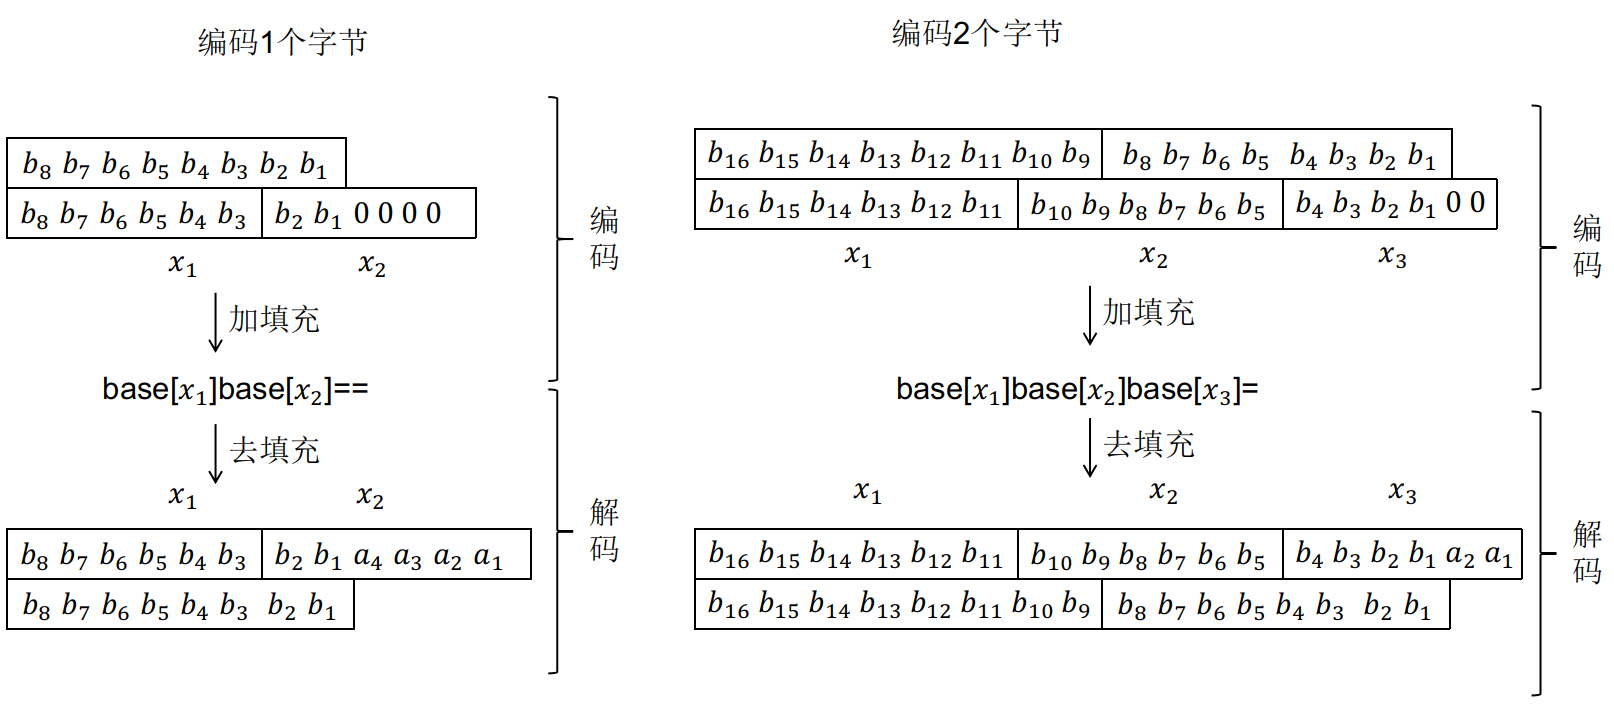

那么，从这里可以看出来一个字节的编码可以隐藏4bit的数据，2字节的编码可以隐藏2bit的数据  
所以针对这道题目，我们需要做的就是把每一行的隐藏数据给找出来